# Vertical Federated Learning

This lab on Vertical Federated Learning (VFL), presents a commonly used architecture called [split learning](https://arxiv.org/abs/1812.00564) to train a neural network. In the classical Horizontal Federated Learning scenario, all clients have access to the same feature space, but have different samples. In contrast, VFL deals with _vertically-partitioned data_, i.e., clients have different features corresponding to the same sample. These two scenarios are indicated in the figures below.

### Horizontal partitioning: HFL

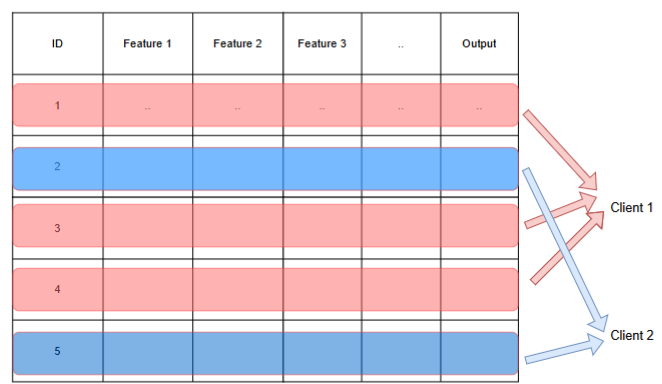

### Vertical partitioning: VFL

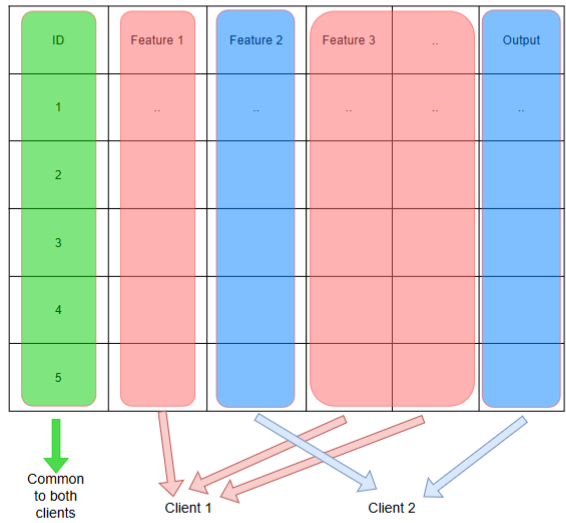

In general, clients in VFL may have different numbers of features and their corresponding types vary significantly. As a result, the local models in VFL may have different architectures in VFL compared to HFL. Below, we see the general architecture of a neural network with a split learning architecture.

### Split learning architecture
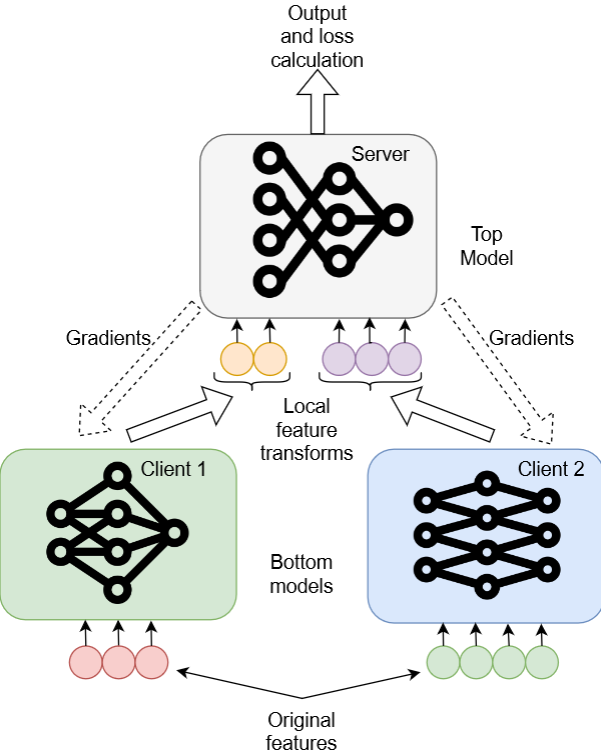

Our objective in this lab is to simulate model training using such an architecture. Towards this end, we first proceed with the necessary library imports as shown below.

In [7]:
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

Following this, we proceed with the code for defining the bottom models located at each client.

In [8]:
class BottomModel(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(BottomModel, self).__init__()
        self.local_out_dim = out_feat
        self.fc1 = nn.Linear(in_feat, out_feat)
        self.fc2 = nn.Linear(out_feat, out_feat)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.act(self.fc1(x))
        return self.dropout(self.act(self.fc2(x)))

Next, we define the top model, i.e., the model located at the server.

In [9]:
class TopModel(nn.Module):
    def __init__(self, local_models, n_outs):
        super(TopModel, self).__init__()
        self.in_size = sum([local_models[i].local_out_dim for i in range(len(local_models))])
        self.fc1 = nn.Linear(self.in_size, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 2)
        self.act = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        concat_outs = torch.cat(x, dim=1)  # concatenate local model outputs before forward pass
        x = self.act(self.fc1(concat_outs))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        return self.dropout(x)

Following the creation of these two components, we combine them together as follows:

In [10]:
class VFLNetwork(nn.Module):
    def __init__(self, local_models, n_outs):
        super(VFLNetwork, self).__init__()
        self.num_cli = None  # the number of clients
        self.cli_features = None  # the set of features corresponding to a client
        self.bottom_models = local_models
        self.top_model = TopModel(self.bottom_models, n_outs)
        self.optimizer = optim.AdamW(self.parameters())
        self.criterion = nn.CrossEntropyLoss()

    def train_with_settings(self, epochs, batch_sz, n_cli, cli_features, x, y):
        self.num_cli = n_cli  
        self.cli_features = cli_features  
        x = x.astype('float32')
        y = y.astype('float32')
        x_train = [torch.tensor(x[feats].values) for feats in cli_features]
        y_train = torch.tensor(y.values)
        num_batches = len(x) // batch_sz if len(x) % batch_sz == 0 else len(x) // batch_sz + 1
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            total_loss = 0.0
            correct = 0.0
            total = 0.0
            for minibatch in range(num_batches):
                if minibatch == num_batches - 1:
                    x_minibatch = [x[int(minibatch * batch_sz):] for x in x_train]
                    y_minibatch = y_train[int(minibatch * batch_sz):]
                else:
                    x_minibatch = [x[int(minibatch * batch_sz):int((minibatch + 1) * batch_sz)] for x in x_train]
                    y_minibatch = y_train[int(minibatch * batch_sz):int((minibatch + 1) * batch_sz)]

                outs = self.forward(x_minibatch)
                pred = torch.argmax(outs, dim=1)
                actual = torch.argmax(y_minibatch, dim=1)
                correct += torch.sum((pred == actual))
                total += len(actual)
                loss = self.criterion(outs, y_minibatch)
                total_loss += loss
                loss.backward()
                self.optimizer.step()

            print(
                f"Epoch: {epoch} Train accuracy: {correct * 100 / total:.2f}% Loss: {total_loss.detach().numpy()/num_batches:.3f}")

    def forward(self, x):
        local_outs = [self.bottom_models[i](x[i]) for i in range(len(self.bottom_models))]
        return self.top_model(local_outs)

    def test(self, x, y):
        x = x.astype('float32')
        y = y.astype('float32')
        x_test = [torch.tensor(x[feats].values) for feats in self.cli_features]
        y_test = torch.tensor(y.values)
        with torch.no_grad():
            outs = self.forward(x_test)
            preds = torch.argmax(outs, dim=1)
            actual = torch.argmax(y_test, dim=1)
            accuracy = torch.sum((preds == actual)) / len(actual)
            loss = self.criterion(outs, y_test)
            return accuracy, loss

In the above code, we create an "aggregate" model that combines the local bottom models and the top server model. Of special note is the training paradigm in VFL. In HFL, training could happen locally at the clients followed by model-averaging at the server. In VFL however, gradients and forward activations need to be propagated as well across the communication boundary. The forward propagation function therefore performs a second forward step following the first forward pass of the local bottom models.

We initialize the training process using the [heart dataset](https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset). This data set dates from 1988 and consists of four databases: Cleveland, Hungary, Switzerland, and Long Beach V.  The predicted output is the presence of heart disease in the patient and is an integer value: 0 = no disease and 1 = disease.

In [11]:
if __name__ == "__main__":
    torch.manual_seed(42)
    np.random.seed(42)
    df = pd.read_csv("heart-dataset/heart.csv")
    categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
    numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    df[numerical_cols] = MinMaxScaler().fit_transform(df[numerical_cols])  # scale numerical features for effective learning
    encoded_df = pd.get_dummies(df, columns=categorical_cols)  #convert categorical features to one-hot embeddings
    num_clients = 4
    X = encoded_df.drop("target", axis=1)
    Y = pd.get_dummies(encoded_df[['target']], columns=['target'])
    features_per_client = (num_clients - 1) * [(len(df.columns) - 1) // num_clients]  # "equally" partition the features
    features_per_client.append(len(df.columns) - 1 - sum(features_per_client))
    features_per_client = np.array(features_per_client)
    all_feature_names = list(df.columns)
    all_feature_names.pop()
    client_feature_names = []
    csum_features_per_client = np.cumsum(features_per_client)
    encoded_df_feature_names = list(X.columns)
    start_index = 0
    end_index = 0
    for num_feats in features_per_client:
        feat_names = all_feature_names[start_index:start_index + num_feats]
        client_feature_names.append(feat_names)
        start_index = start_index + num_feats

    for i in range(len(client_feature_names)):
        updated_names = []
        for column_name in client_feature_names[i]:
            if column_name not in categorical_cols:
                updated_names.append(column_name)
            else:
                for name in encoded_df_feature_names:
                    if '_' in name and column_name in name:
                        updated_names.append(name)

        client_feature_names[i] = updated_names

    # model architecture hyperparameters
    outs_per_client = 2
    bottom_models = [BottomModel(len(in_feats), outs_per_client * len(in_feats)) for in_feats in client_feature_names]
    final_out_dims = 2
    Network = VFLNetwork(bottom_models, final_out_dims)

    #Training configurations
    EPOCHS = 300
    BATCH_SIZE = 64
    TRAIN_TEST_THRESH = 0.8
    X_train, X_test = X.loc[:int(TRAIN_TEST_THRESH * len(X))], X.loc[int(TRAIN_TEST_THRESH * len(X)) + 1:]
    Y_train, Y_test = Y.loc[:int(TRAIN_TEST_THRESH * len(Y))], Y.loc[int(TRAIN_TEST_THRESH * len(Y)) + 1:]
    Network.train_with_settings(EPOCHS, BATCH_SIZE, num_clients,
                                client_feature_names, X_train, Y_train)

    
    accuracy, loss = Network.test(X_test, Y_test)
    print(f"Test accuracy: {accuracy * 100:.2f}%")

Epoch: 0 Train accuracy: 53.96% Loss: 0.693
Epoch: 1 Train accuracy: 68.45% Loss: 0.693
Epoch: 2 Train accuracy: 57.86% Loss: 0.687
Epoch: 3 Train accuracy: 57.61% Loss: 0.663
Epoch: 4 Train accuracy: 62.61% Loss: 0.634
Epoch: 5 Train accuracy: 77.83% Loss: 0.550
Epoch: 6 Train accuracy: 81.00% Loss: 0.468
Epoch: 7 Train accuracy: 74.06% Loss: 0.595
Epoch: 8 Train accuracy: 56.76% Loss: 0.972
Epoch: 9 Train accuracy: 75.03% Loss: 0.533
Epoch: 10 Train accuracy: 72.96% Loss: 0.553
Epoch: 11 Train accuracy: 76.98% Loss: 0.511
Epoch: 12 Train accuracy: 81.85% Loss: 0.447
Epoch: 13 Train accuracy: 81.36% Loss: 0.439
Epoch: 14 Train accuracy: 77.34% Loss: 0.507
Epoch: 15 Train accuracy: 76.13% Loss: 0.537
Epoch: 16 Train accuracy: 80.76% Loss: 0.453
Epoch: 17 Train accuracy: 78.44% Loss: 0.466
Epoch: 18 Train accuracy: 83.43% Loss: 0.435
Epoch: 19 Train accuracy: 79.90% Loss: 0.449
Epoch: 20 Train accuracy: 82.34% Loss: 0.443
Epoch: 21 Train accuracy: 83.07% Loss: 0.437
Epoch: 22 Train accu

Epoch: 184 Train accuracy: 85.99% Loss: 0.358
Epoch: 185 Train accuracy: 84.04% Loss: 0.364
Epoch: 186 Train accuracy: 87.58% Loss: 0.354
Epoch: 187 Train accuracy: 86.48% Loss: 0.349
Epoch: 188 Train accuracy: 85.87% Loss: 0.357
Epoch: 189 Train accuracy: 87.82% Loss: 0.332
Epoch: 190 Train accuracy: 87.70% Loss: 0.330
Epoch: 191 Train accuracy: 86.11% Loss: 0.354
Epoch: 192 Train accuracy: 87.33% Loss: 0.315
Epoch: 193 Train accuracy: 88.43% Loss: 0.317
Epoch: 194 Train accuracy: 87.21% Loss: 0.329
Epoch: 195 Train accuracy: 87.94% Loss: 0.309
Epoch: 196 Train accuracy: 90.01% Loss: 0.292
Epoch: 197 Train accuracy: 88.43% Loss: 0.312
Epoch: 198 Train accuracy: 88.43% Loss: 0.321
Epoch: 199 Train accuracy: 87.58% Loss: 0.318
Epoch: 200 Train accuracy: 88.19% Loss: 0.305
Epoch: 201 Train accuracy: 88.43% Loss: 0.283
Epoch: 202 Train accuracy: 87.09% Loss: 0.309
Epoch: 203 Train accuracy: 87.82% Loss: 0.318
Epoch: 204 Train accuracy: 87.33% Loss: 0.304
Epoch: 205 Train accuracy: 87.33% 